In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from joblib import dump, load
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [46]:
# Hyperparameters
batch_size = 8
n_steps = 10
# input_size = X_train.shape[2] # 24
output_size = 2
num_heads = 2 # should be a factor of input_size
num_layers = 8

predicting_index = 1 # Close price

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, y_binary):
        self.X = X
        self.y = y
        self.y_binary = y_binary

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.y_binary[idx]

class Transformer(nn.Module):
    def __init__(self, input_size, output_size, num_heads, num_layers):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_size, input_size)
        self.transformer = nn.Transformer(
            d_model=input_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
        )
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.embedding(x.float())
        x = x.permute(1, 0, 2)
        tgt = torch.zeros_like(x).to(device)
        out = self.transformer(x, tgt=tgt)
        out = out.permute(1, 0, 2)
        out = self.fc(out[:, -1, :])
        return out[:, 0], torch.sigmoid(out[:, 1])
    
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# load the saved model weights
# weights_path = 'model_parameters_10_2_2_100_128_0.001.pth'
weights_path = 'model_parameters_10_8_2_100_8_0.0001.pth'

# Load, convert and sort the data
# input_filename = "BTCUSDT4Y1MKline.csv"
input_filename = "BTCUSDT4Y1MKline_cleaned_24features_nSteps10.csv"
df = pd.read_csv(input_filename)
df['Open Time'] = pd.to_datetime(df['Open Time'])
df['Open Time'] = df['Open Time'].values.astype(np.int64) // 10 ** 9
df = df.sort_values('Open Time')
length_df = len(df)
df = df.iloc[length_df-2048:length_df]
df=df[['Open Time', 'Close']]
# Use the loaded scaler to transform the new data
#  scaler=MinMaxScaler(feature_range=(0,1))
scaler=load('scaler.joblib')
scaled_data = scaler.transform(df.values)

print(scaled_data.shape)


(2048, 2)


In [48]:
print("scaled_data.shape: ", scaled_data.shape)
print("scaled_date_head", scaled_data[:5])

scaled_data.shape:  (2048, 2)
scaled_date_head [[-1.37371920e+04 -8.92562995e-01]
 [-1.37371920e+04 -9.43608225e-01]
 [-1.37371920e+04 -9.34743570e-01]
 [-1.37371920e+04 -9.42832771e-01]
 [-1.37371920e+04 -9.46995731e-01]]


In [39]:
# load the saved model weights
weights_path = 'model_parameters_10_2_2_100_16_0.0001.pth'
scaler=load('scaler.joblib')


Accuracy on Test Data: 0.4991176426410675
Average Error on Test Data (percentage terms): 6.854710479145947%


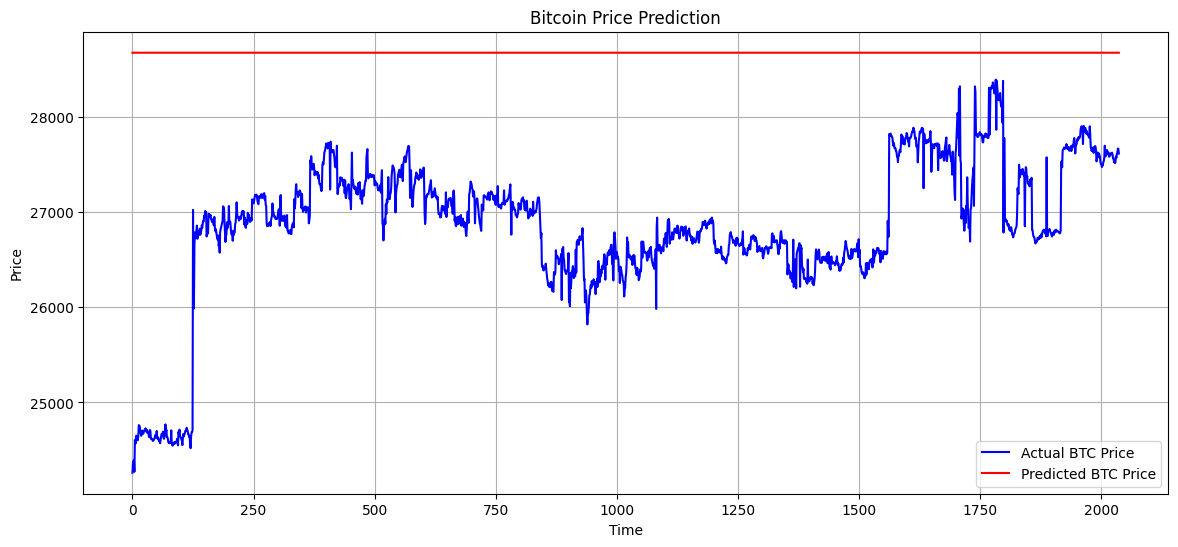

In [51]:
X = []
y = []
y_binary = []

for i in range(n_steps, len(scaled_data)-1):
    X.append(scaled_data[i - n_steps:i])
    y.append(scaled_data[i, predicting_index])
X = np.array(X)
X = torch.from_numpy(X).float().to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

for i in range(n_steps, len(scaled_data) - 1):
    y_binary.append(int(scaled_data[i + 1, predicting_index] > scaled_data[i, predicting_index]))
y_binary = torch.tensor(y_binary, dtype=torch.float32).to(device)


train_size = int(len(X) * 0)
val_size = int(len(X) * 0) # additional
# adjusted indices to create validation set
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
y_train_binary, y_val_binary, y_test_binary = y_binary[:train_size], y_binary[train_size:train_size + val_size], y_binary[train_size + val_size:]

# Convert data to PyTorch tensors and create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train, y_train_binary)
val_dataset = TimeSeriesDataset(X_val, y_val, y_val_binary)
test_dataset = TimeSeriesDataset(X_test, y_test, y_test_binary)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[2]

# instantiate the model and load the weights
model = Transformer(input_size, output_size, num_heads, num_layers)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
model.to(device)

model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

# switch the model to evaluation mode
model.eval()

# initialize arrays to store predictions and actual values
test_preds = []
test_actuals = []
accuracy=0
# perform the testing
with torch.no_grad():
    for i, (batch_X, batch_y_continuous, batch_y_binary) in enumerate(test_loader):
        batch_y_continuous = batch_y_continuous.float().to(device)
        batch_y_binary = batch_y_binary.to(device)
        batch_X = batch_X.to(device)
        outputs, outputs_binary = model(batch_X.float())
        accuracy += (outputs_binary.round() == batch_y_binary).float().mean()
        test_preds.append(outputs.detach().cpu().numpy())
        test_actuals.append(batch_y_continuous.detach().cpu().numpy())

# compute the accuracy
accuracy = accuracy / len(test_loader)
print(f"Accuracy on Test Data: {accuracy}")

# convert lists to numpy arrays
test_preds = np.concatenate(test_preds)
test_actuals = np.concatenate(test_actuals)

# compute mean squared error on test data
mse_test = mean_squared_error(test_actuals, test_preds)
# print(f"Mean Squared Error on Test Data: {mse_test}")

# Create dummy arrays
n_features = df.shape[1] # assuming df is your original DataFrame before scaling
dummy_preds = np.zeros((len(test_preds), n_features))
dummy_actuals = np.zeros((len(test_actuals), n_features))

# Replace the 'Close' price column with your predictions/actuals
dummy_preds[:, predicting_index] = test_preds
dummy_actuals[:, predicting_index] = test_actuals

# Now you can inverse transform
test_preds_inv = scaler.inverse_transform(dummy_preds)[:, predicting_index]
test_actuals_inv = scaler.inverse_transform(dummy_actuals)[:, predicting_index]

# # Compute mean squared error on inverse transformed (original scale) data
# mse_test_inv = mean_squared_error(test_actuals_inv, test_preds_inv)
# print(f"Mean Squared Error on Test Data (original scale): {mse_test_inv}")

# Compute errors on inverse transformed (original scale) data
errors_inv = test_actuals_inv - test_preds_inv
# Convert errors to percentage terms
percentage_errors = np.abs(errors_inv / test_actuals_inv) * 100
# Compute average of the percentage errors
average_percentage_error = np.mean(percentage_errors)
print(f"Average Error on Test Data (percentage terms): {average_percentage_error}%")


# Plotting actual vs predicted prices
plt.figure(figsize=(14,6))
plt.plot(test_actuals_inv, color='blue', label='Actual BTC Price')
plt.plot(test_preds_inv, color='red', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print("test_preds_inv.shape: ", test_preds_inv.shape)

test_preds_inv.shape:  (97884,)


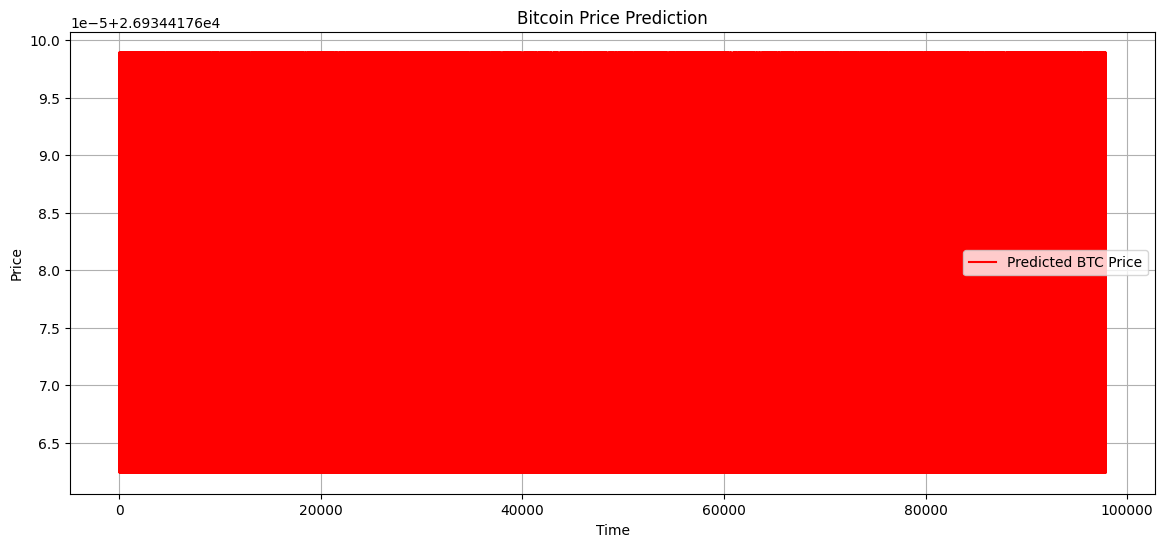

In [12]:
# plot only the test_predictions_inv:
plt.figure(figsize=(14,6))
plt.plot(test_preds_inv, color='red', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
print(test_preds_inv.shape)

(97884,)


In [20]:
print("test_preds_inv: ", test_preds_inv)

test_preds_inv:  [26934.41769892 26934.41769892 26934.41769892 ... 26934.4176624
 26934.4176624  26934.41769892]


In [16]:
# check if all of the values in test_preds_inv are equal
print(np.all(test_preds_inv == test_preds_inv[0]))

False


In [17]:
# print any values that are not equal:
print(test_preds_inv[np.where(test_preds_inv != test_preds_inv[0])])

[26934.4176624 26934.4176624 26934.4176624 ... 26934.4176624 26934.4176624
 26934.4176624]


In [18]:
new_test_pred = test_preds_inv[np.where(test_preds_inv != test_preds_inv[0])]
print(new_test_pred.shape)

(42716,)


In [26]:
# calculate mean of df['Close'] column
mean = df['Close'].mean()
print(mean)

26984.90618562112


In [27]:
# caclulate median of df['Close'] column
median = df['Close'].median()
print(median)

23139.43
